# Deep Learning using Keras-Session 04

We will cover how to develop real-world deep learning models using Keras.

Today, we will go deeper into keras and see how to do the following:


*  Read data from folders using its path stored in Excel file
*  Transfer Learning









**This is when we all dataset in one folders (no testing & training). There are csv files that have the name of images that we want for each split.**

### Dataset Reading

This tutorial uses a <a href="http://download.tensorflow.org/example_images/flower_photos.tgz"> dataset </a> of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
dataset/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

If the data is already uploaded to Google Drive, we need to add these lines of code to give Colab authority to access them.

In [1]:
# give permission to colab to access your file
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


After reaching to the data, we can count the number of images.


In [2]:
import glob
experiment_dir = '/content/gdrive/My Drive/DeepLearning-Keras/flower_photos'
image_count = len(glob.glob(experiment_dir+'/*/*.jpg'))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

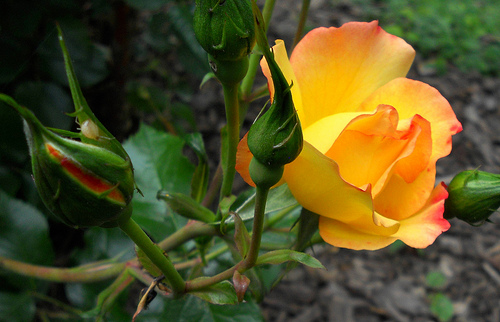

In [4]:
import PIL
import PIL.Image
roses = list(glob.glob(experiment_dir+'/roses/*'))
PIL.Image.open(str(roses[0]))

## Load data using a Keras utility

Let's load these images from the disk. There are several methods to read the data from the disk. In this session, we will read the data base on their paths stored in csv file: .

1.   Using the helpful `ImageDataGenerator.flow_from_directory` utility (covered last session)
2.   Using the helpful `ImageDataGenerator.flow_from_dataframe` utility to read the data based on csv (or Excel) file.



### Create a dataset and Data augmentation
In this part, we will create `ImageDataGenerator` for data augmentation, then we will read the data using `ImageDataGenerator.flow_from_dataframe`:


In [5]:
#Define some parameters for the loader
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.utils import shuffle

# ImageDataGenrator used for split data and perform data augmentation
datagen_train = ImageDataGenerator(rotation_range=40,
        horizontal_flip=True,
        fill_mode='nearest', validation_split=0.2)

datagen_test = ImageDataGenerator()


train_path ='/content/gdrive/My Drive/DeepLearning-Keras/flower_photos/train.csv'

train_df = pd.read_csv(train_path,names=['label','sPath'],header=None, dtype=str)
train_df = shuffle(train_df)
#change images path to the new path in Google Drive
train_df["sPath"] = experiment_dir + train_df.sPath


print(train_df)
print(train_df.label)

test_path ='/content/gdrive/My Drive/DeepLearning-Keras/flower_photos/test.csv'
test_df = pd.read_csv(test_path,names=['label','sPath'],header=None, dtype=str)
#change images path to the new path in Google Drive
test_df["sPath"] = experiment_dir + test_df.sPath

train_ds = datagen_train.flow_from_dataframe(dataframe=train_df, directory=None, x_col="sPath", y_col="label", batch_size=64, class_mode='categorical', subset = "training", target_size=(img_width, img_height), shuffle=True, seed=42)
val_ds  = datagen_train.flow_from_dataframe(dataframe=train_df,  directory=None, x_col="sPath", y_col="label", batch_size=64, class_mode='categorical', subset = "validation", target_size=(img_width, img_height), shuffle=True, seed=42)
test_ds = datagen_test.flow_from_dataframe(dataframe=test_df,  directory=None, x_col="sPath", y_col="label", batch_size=64, class_mode='categorical', target_size=(img_width, img_height), shuffle=False)

#To know number of samples per set use: train_ds.n



           label                                              sPath
2646      tulips  /content/gdrive/My Drive/DeepLearning-Keras/fl...
189        daisy  /content/gdrive/My Drive/DeepLearning-Keras/fl...
2050  sunflowers  /content/gdrive/My Drive/DeepLearning-Keras/fl...
1542       roses  /content/gdrive/My Drive/DeepLearning-Keras/fl...
917    dandelion  /content/gdrive/My Drive/DeepLearning-Keras/fl...
...          ...                                                ...
2315      tulips  /content/gdrive/My Drive/DeepLearning-Keras/fl...
306        daisy  /content/gdrive/My Drive/DeepLearning-Keras/fl...
1185   dandelion  /content/gdrive/My Drive/DeepLearning-Keras/fl...
2586      tulips  /content/gdrive/My Drive/DeepLearning-Keras/fl...
1440       roses  /content/gdrive/My Drive/DeepLearning-Keras/fl...

[2917 rows x 2 columns]
2646        tulips
189          daisy
2050    sunflowers
1542         roses
917      dandelion
           ...    
2315        tulips
306          daisy
1185   

class_mode='categorical:
- To class_mode='categorical'  to convert text cateogries into numbers automatecally


### Visualize the data

Here are the first nine images from the training dataset.

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


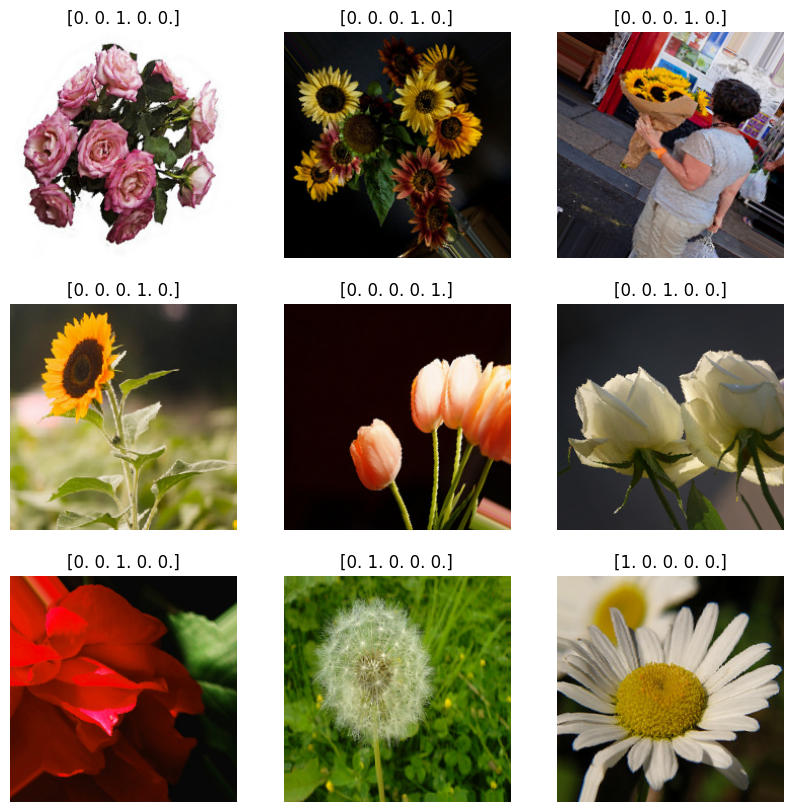

In [8]:
import matplotlib.pyplot as plt
import numpy as np



plt.figure(figsize=(10, 10))
images, labels = next(train_ds)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i,:,:,:].astype("uint8"))
  plt.title(labels[i])
  plt.axis("off")




You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [9]:
x, y = next(train_ds)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64, 5)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

## Building models with the Keras Functional API

After defining your input(s), you can chain layer transformations on top of your inputs,
 until your final output:

 Extract features from images via transfer learning

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications.mobilenet import preprocess_input

def transfer_learning():

    
  input_img = Input(shape=(224, 224, 3)) # you should use size of the model trained


  input_img = preprocess_input(input_img) # use pre-processing for the specific model that was used by that model

  model_cnn = tf.keras.applications.MobileNet(weights="imagenet", include_top=False, input_tensor=input_img)

  # retrain last four layers (trainable)
  for layer in model_cnn.layers[:-4]:
       layer.trainable = True
        
        
  # add some layers
  cnn_out = GlobalAveragePooling2D()(model_cnn.output)  # Instead of flatting [3d to 1d]
            # ex: 7x7x1248 -->  1248 by taaking the average values of the 7x7
  cnn_out = Dropout(0.5)(cnn_out)

  cnn_out = Dense(5, activation="softmax")(cnn_out)
  model = tf.keras.models.Model(inputs = model_cnn.input, outputs = cnn_out)

  return model

In [11]:
myModel = transfer_learning()


17225924/17225924 [==============================] - 0s 0us/step


In [12]:
# Let's check out what the model summary looks like:
myModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                             

You can also plot the model as a graph:

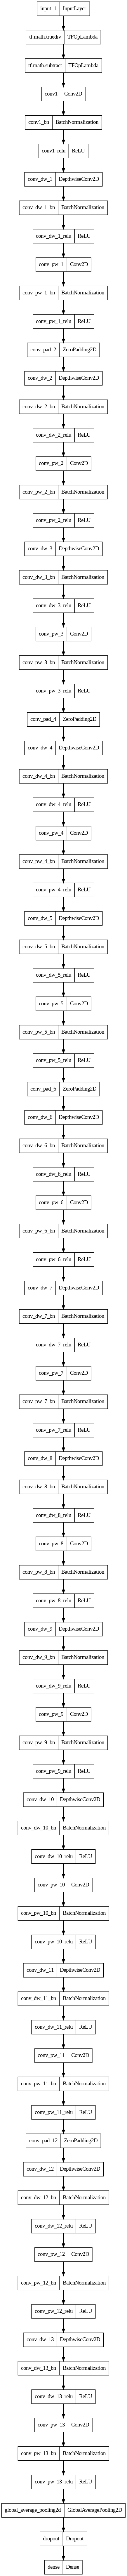

In [13]:
import tensorflow.keras.utils as utils
utils.plot_model(myModel, "my_first_model.png")

And, optionally, display the input and output shapes of each layer in the plotted graph:

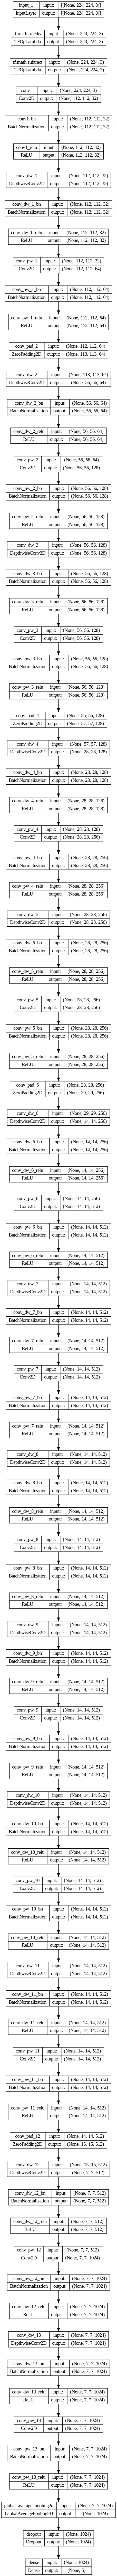

In [14]:
utils.plot_model(myModel, "my_first_model_with_shape_info.png", show_shapes=True)

In [15]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam as adam

myModel.compile(optimizer=adam(learning_rate=1e-3),
              loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])

Note: You will only train the model with Early stopping technique and we will save the best model (lowest validation accuracy) in the experiment folder.

In [2]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode="min")
#chkPoints = ModelCheckpoint(filepath='path/to/my/model_{epoch}', save_freq='epoch') # all models will be saved

chkPoints = ModelCheckpoint(filepath=experiment_dir+'/best_model.h5',verbose = 1, save_best_only = True) #save only best model

modelHistory = myModel.fit(train_ds, validation_data=val_ds, epochs=1000, callbacks=[early_stopping, chkPoints])


Epoch 1/1000
 6/37 [===>..........................] - ETA: 9:23 - loss: 1.3042 - accuracy: 0.5807

KeyboardInterrupt: ignored

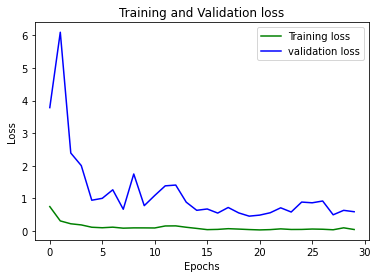

In [ ]:
loss_train = modelHistory.history['loss']
loss_val = modelHistory.history['val_loss']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


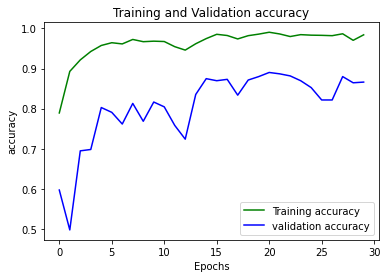

In [ ]:
acc_train = modelHistory.history['accuracy']
acc_val = modelHistory.history['val_accuracy']
epochs = range(len(acc_train))
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
model = tf.keras.models.load_model(experiment_dir+'/best_model.h5')

loss, acc = model.evaluate(test_ds)
print("Testing accuracy is: ", acc)